<a href="https://colab.research.google.com/github/rosshalpin/AdvancedML/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/AdvancedML/

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/My Drive/AdvancedML


In [2]:
import pandas as pd

df = pd.read_csv("tweets.1650486802.csv")

In [3]:
import re

def remove_usernames(text):
  return re.sub(r'@([^\s]+)', '', text)

def remove_hyperlinks(text):
  return re.sub(r'http\S+|www.\S+|https', '', text)

df.text = df.text.apply(remove_usernames)
df.text = df.text.apply(remove_hyperlinks)
df = df.drop_duplicates()
df = df.drop(df.query('sentiment == "neutral"').sample(frac=.64, random_state=109).index)
df.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


Y = pd.get_dummies(df.sentiment).values

max_features = 100

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.text)

X = pad_sequences(tokenizer.texts_to_sequences(df.text))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=409, shuffle=True)

In [6]:
import torch
torch.cuda.is_available()

True

In [74]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

from keras.callbacks import History 
history = History()

embed_dim = 20
lstm_out = 5

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 42, 20)            2000      
                                                                 
 lstm_22 (LSTM)              (None, 5)                 520       
                                                                 
 dense_22 (Dense)            (None, 3)                 18        
                                                                 
Total params: 2,538
Trainable params: 2,538
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
batch_size = 32
history2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 40, batch_size=batch_size, verbose = 2, callbacks=[history])

Epoch 1/40
34/34 - 9s - loss: 1.0961 - accuracy: 0.3764 - val_loss: 1.0893 - val_accuracy: 0.4301 - 9s/epoch - 267ms/step
Epoch 2/40
34/34 - 6s - loss: 1.0869 - accuracy: 0.4045 - val_loss: 1.0776 - val_accuracy: 0.4127 - 6s/epoch - 187ms/step
Epoch 3/40
34/34 - 6s - loss: 1.0743 - accuracy: 0.4429 - val_loss: 1.0599 - val_accuracy: 0.4629 - 6s/epoch - 182ms/step
Epoch 4/40
34/34 - 6s - loss: 1.0580 - accuracy: 0.4757 - val_loss: 1.0398 - val_accuracy: 0.4978 - 6s/epoch - 182ms/step
Epoch 5/40
34/34 - 6s - loss: 1.0405 - accuracy: 0.5122 - val_loss: 1.0210 - val_accuracy: 0.5044 - 6s/epoch - 187ms/step
Epoch 6/40
34/34 - 6s - loss: 1.0235 - accuracy: 0.5253 - val_loss: 0.9976 - val_accuracy: 0.5371 - 6s/epoch - 190ms/step
Epoch 7/40
34/34 - 6s - loss: 1.0038 - accuracy: 0.5309 - val_loss: 0.9726 - val_accuracy: 0.5655 - 6s/epoch - 183ms/step
Epoch 8/40
34/34 - 6s - loss: 0.9800 - accuracy: 0.5506 - val_loss: 0.9583 - val_accuracy: 0.5764 - 6s/epoch - 181ms/step
Epoch 9/40
34/34 - 6s - 

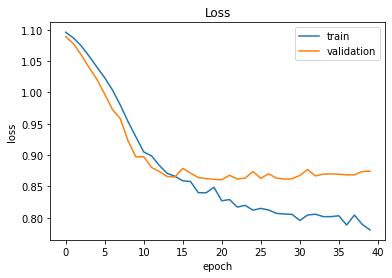

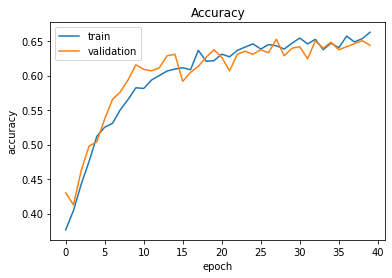

In [76]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [77]:
model.save('dnn')

INFO:tensorflow:Assets written to: dnn/assets
